In [ ]:
!date

# Class DE isoform hidden by gene

In [70]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [130]:
subclass_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [131]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [132]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [133]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [134]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [135]:
print(isoform.shape)
print(gene.shape)

(7843, 66698)
(7843, 21420)


In [136]:
gene.obs.subclass_label.value_counts()

CA1-ProS         1391
L6b/CT ENT        624
L3 IT ENT         569
Sst               494
SUB-ProS          442
Vip               388
L2/3 IT CTX       338
L2/3 IT ENTl      310
L4/5 IT CTX       307
DG                286
Pvalb             276
CA3               269
NP SUB            242
Lamp5             241
Sncg              198
L2  IT ENTl       175
L5 IT TPE-ENT     144
L6 CT CTX         138
L2/3 IT RHP       127
CT SUB            121
L6 IT CTX         118
L5 IT CTX         102
L2/3 IT PPP        91
Astro              90
L6 IT ENTl         68
Meis2              61
L6b CTX            59
L2 IT ENTm         41
NP PPP             29
L5 NP CTX          24
L5 PT CTX          18
Car3               16
Sst Chodl          12
IG-FC              11
L5 PPP              9
Micro-PVM           8
L4 RSP-ACA          3
CR                  2
Oligo               1
Name: subclass_label, dtype: int64

In [137]:
regions = gene.obs.region_label.unique()
subclasses = gene.obs.subclass_label.unique()
breakdown = pd.DataFrame(index=subclasses, columns=regions)
for region in regions:
    m = gene.obs.region_label == region
    r = gene.obs[m]
    d = r.subclass_label.value_counts()
    d = d.to_dict()
    breakdown[region] = breakdown.index.map(d)
breakdown

,HIP,ORB,ENTm,ENTl,SUB-ProS
CA1-ProS,1280,0,0,2,109
DG,286,0,0,0,0
CA3,269,0,0,0,0
IG-FC,11,0,0,0,0
L2/3 IT RHP,3,0,18,16,90
NP SUB,9,0,0,0,233
SUB-ProS,20,0,0,1,421
L6 CT CTX,2,104,2,3,27
L6b CTX,1,8,14,19,17
L4/5 IT CTX,0,278,0,28,1


In [138]:
c = 3 #minimum number of columns that must satisfy criteria
n = 50 #minimum number of cells
b = breakdown.applymap(lambda x: x >=n)
for region in regions:
    b[region] = b[region].map({True:1,False:0})
m2 = b.sum(axis=1) >= c
f_breakdown =breakdown[m2]
f_breakdown

,HIP,ORB,ENTm,ENTl,SUB-ProS
Vip,0,111,72,103,102
Pvalb,0,22,93,79,82
Sst,0,75,126,76,217
Lamp5,0,56,95,65,25


In [139]:
def gene_dexpress(c_gene):
    mat           = c_gene.layers["log1p"].todense()
    components    = c_gene.obs.cell_id.values
    features      = c_gene.var.gene_name.values
    assignments   = c_gene.obs.region_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
    markers_gene = markers_gene.query("es > 0")
    return markers_gene

In [140]:
def isoform_dexpress(c_isoform):
    mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
    components  = c_isoform.obs.cell_id.values
    features    = c_isoform.var.transcript_name.values
    assignments = c_isoform.obs.region_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
    markers_isoform = markers_isoform.query("es > 0")
    return markers_isoform

In [141]:
f_breakdown.index

CategoricalIndex(['Vip', 'Pvalb', 'Sst', 'Lamp5'], categories=['CA1-ProS', 'DG', 'CA3', 'IG-FC', 'L2/3 IT RHP', 'NP SUB', 'SUB-ProS', 'L6 CT CTX', ...], ordered=False, dtype='category')

In [142]:
f_breakdown.index[3]

'Lamp5'

In [143]:
markers_gene = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','subclass'])
markers_isoform = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','subclass'])
for subclass in f_breakdown.index:
    mask = np.logical_and(gene.obs.subclass_label == subclass, np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
    c_gene = gene[mask]
    c_isoform = isoform[mask]
    temp_gene = gene_dexpress(c_gene)
    temp_gene['subclass'] = subclass
    markers_gene = pd.concat([markers_gene,temp_gene])
    temp_isoform = isoform_dexpress(c_isoform)
    temp_isoform['subclass'] = subclass
    markers_isoform = pd.concat([markers_isoform,temp_isoform])
    

21-Jul-21 16:46:33 - 1 of 4 assignments: ENTl
21-Jul-21 16:46:33 - 2 of 4 assignments: ENTm
21-Jul-21 16:46:33 - 3 of 4 assignments: ORB
21-Jul-21 16:46:33 - 4 of 4 assignments: SUB-ProS
21-Jul-21 16:46:34 - 1 of 4 assignments: ENTl
21-Jul-21 16:46:34 - 2 of 4 assignments: ENTm
21-Jul-21 16:46:34 - 3 of 4 assignments: ORB
21-Jul-21 16:46:34 - 4 of 4 assignments: SUB-ProS
21-Jul-21 16:46:35 - 1 of 4 assignments: ENTl
21-Jul-21 16:46:35 - 2 of 4 assignments: ENTm
21-Jul-21 16:46:35 - 3 of 4 assignments: ORB
21-Jul-21 16:46:35 - 4 of 4 assignments: SUB-ProS
21-Jul-21 16:46:36 - 1 of 4 assignments: ENTl
21-Jul-21 16:46:36 - 2 of 4 assignments: ENTm
21-Jul-21 16:46:36 - 3 of 4 assignments: ORB
21-Jul-21 16:46:36 - 4 of 4 assignments: SUB-ProS
21-Jul-21 16:46:36 - 1 of 4 assignments: ENTl
21-Jul-21 16:46:36 - 2 of 4 assignments: ENTm
21-Jul-21 16:46:37 - 3 of 4 assignments: ORB
21-Jul-21 16:46:37 - 4 of 4 assignments: SUB-ProS
21-Jul-21 16:46:38 - 1 of 4 assignments: ENTl
21-Jul-21 16:46:38 

In [144]:
#mask = np.logical_and(gene.obs.subclass_label == 'Vip', np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
#mask = (gene.obs.subclass_label == 'Vip')

#c_gene = gene[mask]
#c_isoform = isoform[mask]
#markers_gene= gene_dexpress(c_gene)
#markers_isoform = isoform_dexpress(c_isoform)

# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [145]:
alpha =0.01/len(f_breakdown.index) #second bonferroni correction for multiple subclasses being tested
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [146]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es,index_name,subclass
171989,ORB,Fau-201_ENSMUST00000043074.14,8.71841e-09,2.45249e-05,2.10292,ORB_Fau,Pvalb
141527,ORB,Anapc16-201_ENSMUST00000020307.11,2.91674e-14,8.2048e-11,1.56294,ORB_Anapc16,Pvalb
54403,ENTl,Lgals1-202_ENSMUST00000229159.2,3.14527e-08,9.0741e-05,1.47406,ENTl_Lgals1,Sst
54404,ENTl,Lgals1-201_ENSMUST00000089377.6,6.03982e-07,0.00174249,1.43035,ENTl_Lgals1,Sst
227966,SUB-ProS,Ing4-203_ENSMUST00000128277.2,4.42678e-17,1.27624e-13,1.42229,SUB-ProS_Ing4,Sst
226147,SUB-ProS,Nos1-206_ENSMUST00000142742.9,7.98217e-07,0.00210809,1.34174,SUB-ProS_Nos1,Lamp5
134356,ORB,Chordc1-208_ENSMUST00000217031.2,3.54845e-11,6.56819e-08,1.2202,ORB_Chordc1,Vip
178376,ORB,Hnrnph2-202_ENSMUST00000059297.6,1.2432e-06,0.00230116,1.15194,ORB_Hnrnph2,Vip
242715,SUB-ProS,Trpc5-201_ENSMUST00000040184.4,5.41816e-07,0.00143094,1.12178,SUB-ProS_Trpc5,Lamp5
143548,ORB,Rtn1-205_ENSMUST00000150156.2,8.39311e-08,0.000281505,1.10697,ORB_Rtn1,Sst


In [147]:
markers_gene[markers_gene.name.str.contains("Anapc16")]
#markers_gene[markers_gene.name.str.contains("Kifap")]

,index,name,p_raw,p_corr,es,index_name,subclass
1806,ENTl,Anapc16_ENSMUSG00000020107.11,0.0343081,1,0.308899,ENTl_Anapc16,Vip
1806,ENTl,Anapc16_ENSMUSG00000020107.11,0.310099,1,0.0765165,ENTl_Anapc16,Pvalb
23226,ENTm,Anapc16_ENSMUSG00000020107.11,0.420726,1,0.0300999,ENTm_Anapc16,Pvalb
44646,ORB,Anapc16_ENSMUSG00000020107.11,0.00350019,1,0.38687,ORB_Anapc16,Pvalb
44646,ORB,Anapc16_ENSMUSG00000020107.11,0.429735,1,0.0202693,ORB_Anapc16,Sst
66066,SUB-ProS,Anapc16_ENSMUSG00000020107.11,0.0278886,1,0.180587,SUB-ProS_Anapc16,Sst
1806,ENTl,Anapc16_ENSMUSG00000020107.11,0.0324629,1,0.236108,ENTl_Anapc16,Lamp5
66066,SUB-ProS,Anapc16_ENSMUSG00000020107.11,0.148514,1,0.157522,SUB-ProS_Anapc16,Lamp5


In [148]:
#specific_cluster = "Glutamatergic"
#specific_gene = "Kifap3_ENSMUSG00000026585.14"
#specific_isoform = "Kifap3-202_ENSMUST00000077642.12"

#specific_cluster = "ENTl"
specific_cluster = "ORB"
specific_gene = "Anapc16_ENSMUSG00000020107.11"
specific_isoform = "Anapc16-201_ENSMUST00000020307.11"
specific_subclass = 'Pvalb'

In [149]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


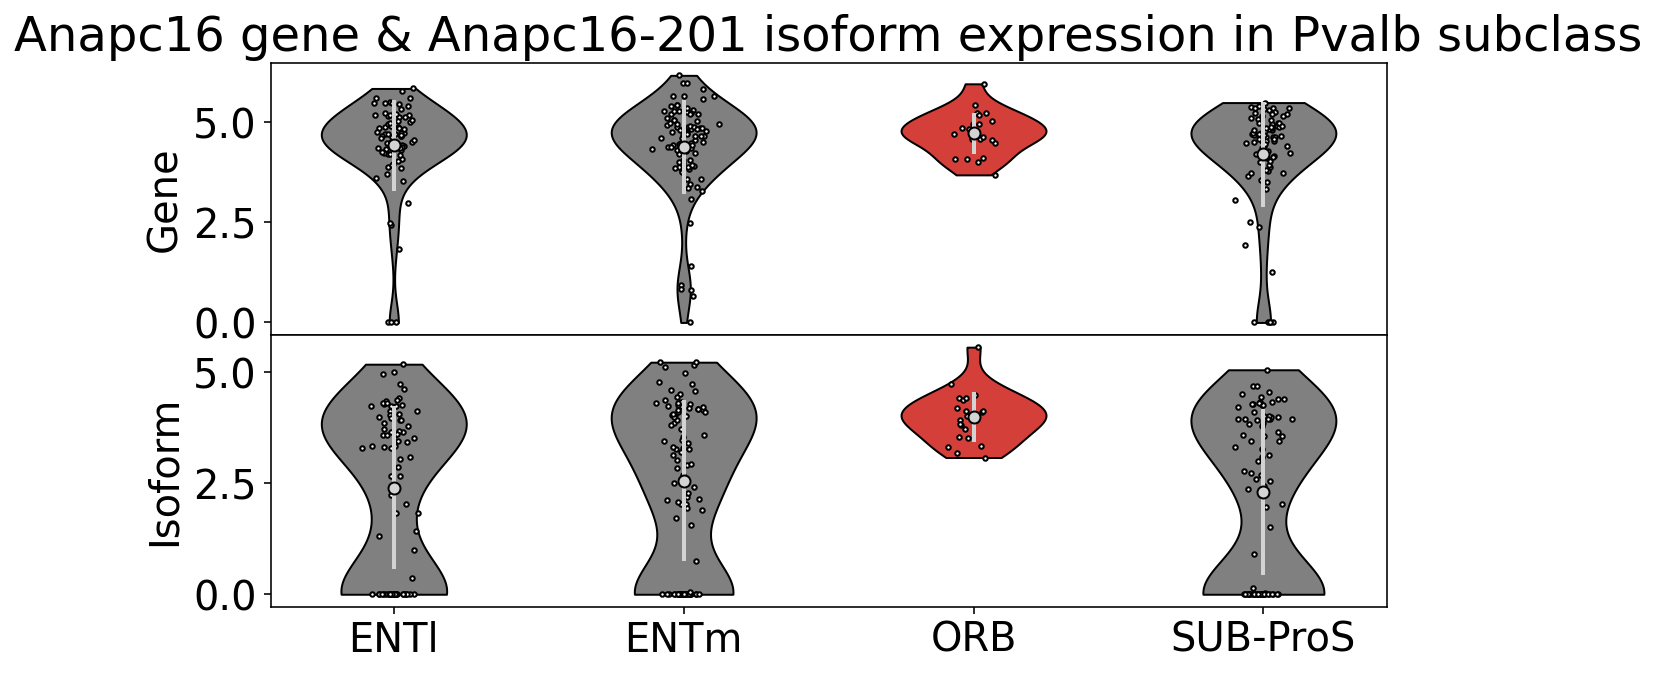

In [150]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

mask = np.logical_and(gene.obs.subclass_label == specific_subclass, np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
c_gene = gene[mask]
c_isoform = isoform[mask]
# Declare
unique = np.unique(c_gene.obs.region_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(c_gene[c_gene.obs.region_label==c][:,c_gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(c_isoform[c_isoform.obs.region_label==c][:,c_isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)
## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression in {} subclass".format(specific_gene.split("_")[0], specific_isoform.split("_")[0],specific_subclass),
    "ylabel":"Gene",
})

#need to figure out what ax[0] and ax[1] are
ymin, ymax = ax[1].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/region_subclass_DE_violin_all.png", bbox_inches='tight',dpi=300)
plt.show()

# gene.obs

In [151]:
#c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
isoform[:, isoform.var.transcript_name==specific_isoform]

View of AnnData object with n_obs × n_vars = 7843 × 1
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

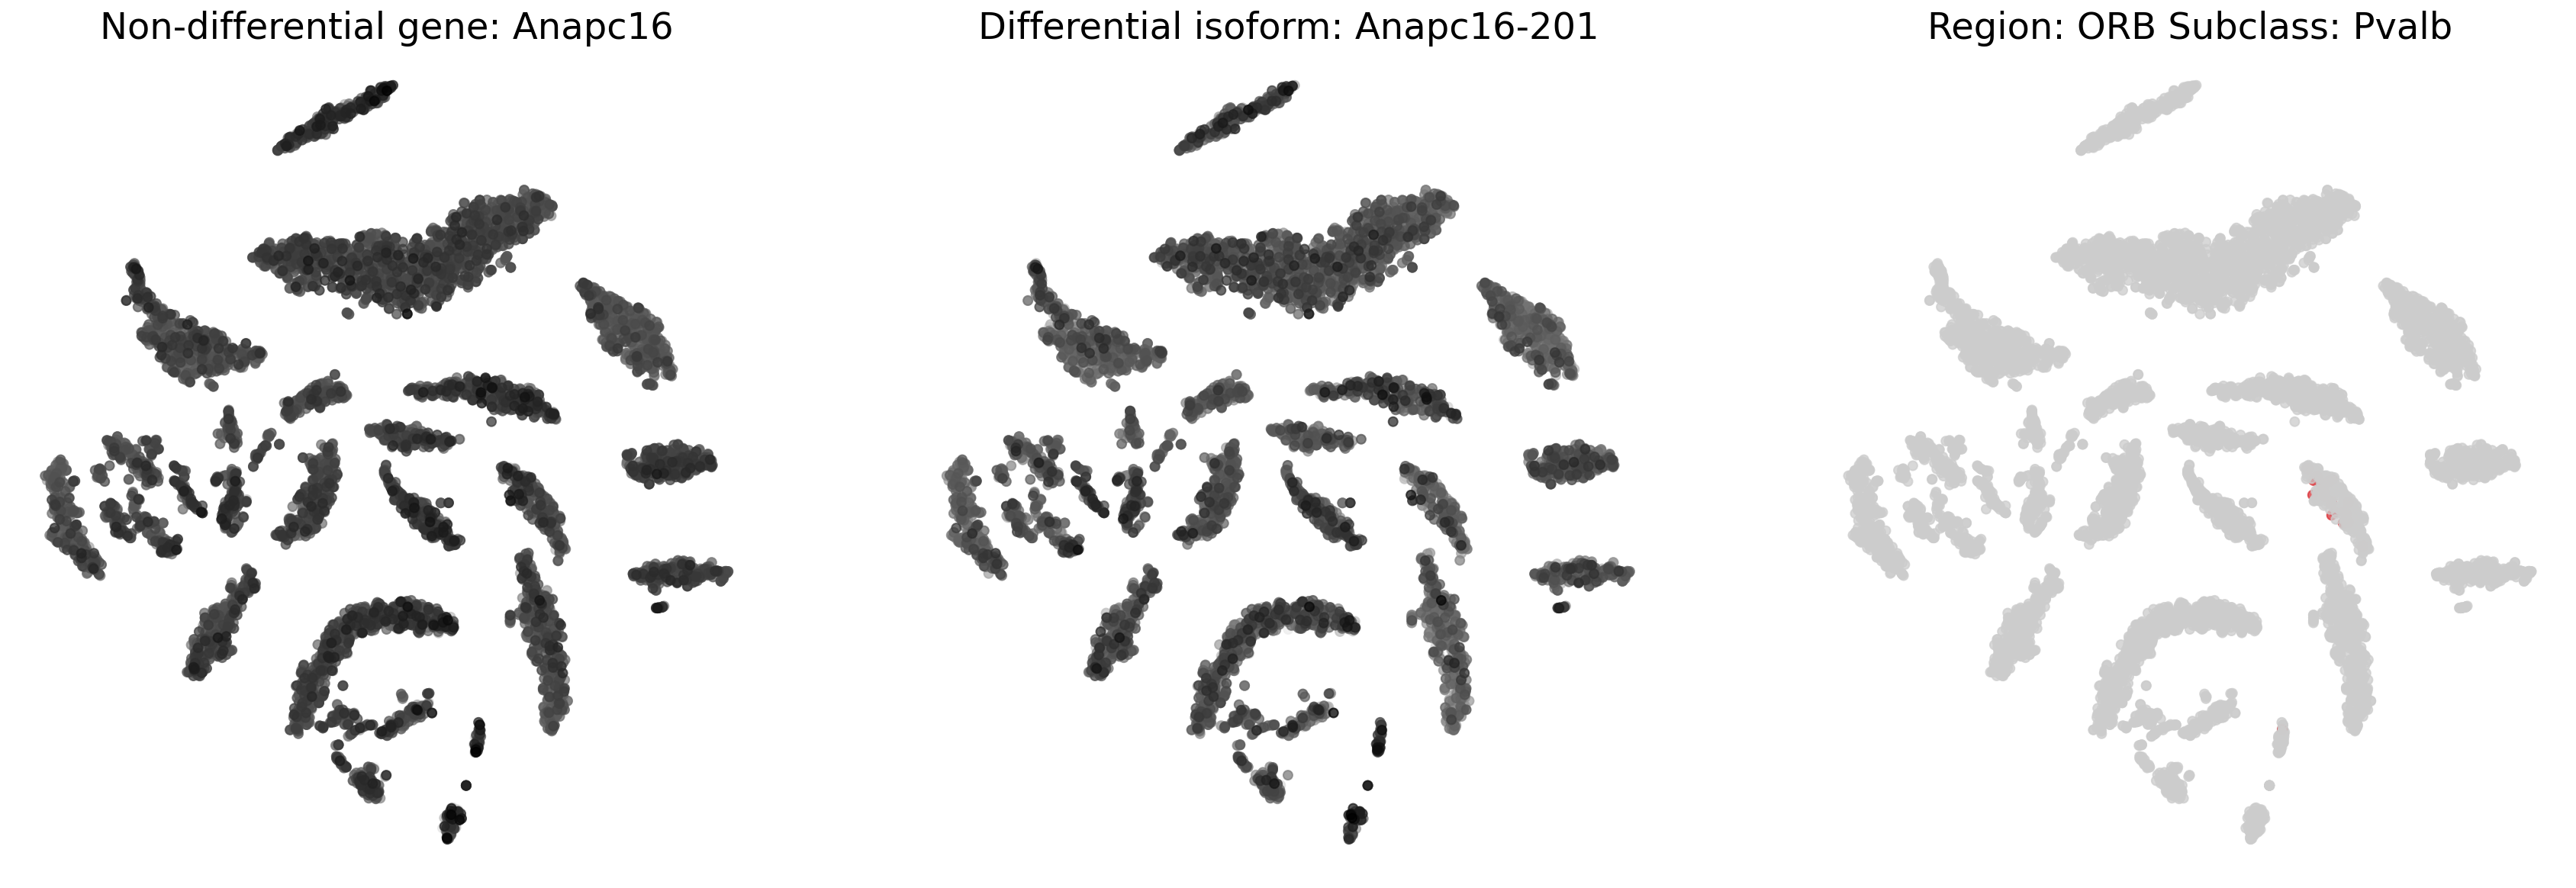

In [161]:
#this figure doesnt really make sense to be used
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(np.logical_or(gene.obs["region_label"]!=specific_cluster, gene.obs["subclass_label"]!=specific_subclass))[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Region: {} Subclass: {}".format(specific_cluster,specific_subclass))
plt.savefig("../../figures/region_subclass_DE_nca_all.png", bbox_inches='tight',dpi=300)
plt.show()

In [153]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [154]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [155]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

133 isoforms from 108 genes identified.


In [162]:
markers_isoform.to_csv("../../tables/unordered/region_subclass_DE.csv")